# Quick introduction

## Reading and plotting

In [1]:
from pathlib import Path


#put relative path in here
path = Path('i06_original_resolution_cnv')
#final file name here
fname = path.joinpath('05001.cnv.zip')

In [2]:
import ctd


cast = ctd.from_cnv(fname)
down, up = cast.split()

down.head()

,depSM,t090C,c0mS/cm,t190C,c1mS/cm,sal00,sal11,sbox0Mm/Kg,flECO-AFL,turbWETbb0,...,v4,v5,v7,latitude,longitude,timeS,sbeox0V,timeY,altM,flag
Pressure [dbar],,,,,,,,,,,,,,,,,,,,,
0.320,0.318,14.2729,0.071797,14.1887,0.036455,0.0450,0.0251,183.420,0.1013,0.006699,...,4.9988,0.0,0.0,-34.5577,29.50868,0.000,1.6288,1.557452e+09,99.98,False
0.320,0.318,14.2727,0.071734,14.1889,0.036366,0.0450,0.0250,183.421,0.1013,0.006702,...,4.9963,0.0,0.0,-34.5577,29.50868,0.042,1.6288,1.557452e+09,99.93,False
0.362,0.360,14.2731,0.071890,14.1889,0.036455,0.0450,0.0251,183.420,0.1013,0.006702,...,4.9963,0.0,0.0,-34.5577,29.50868,0.083,1.6288,1.557452e+09,99.93,False
0.320,0.318,14.2732,0.071984,14.1892,0.036485,0.0451,0.0251,183.419,0.1013,0.006699,...,4.9988,0.0,0.0,-34.5577,29.50868,0.125,1.6288,1.557452e+09,99.98,False
0.353,0.350,14.2734,0.071828,14.1893,0.036425,0.0450,0.0251,183.419,0.1013,0.006702,...,4.9963,0.0,0.0,-34.5577,29.50868,0.167,1.6288,1.557452e+09,99.93,False


It is a `pandas.DataFrame` with all the pandas methods and properties.

In [3]:
type(cast)

pandas.core.frame.DataFrame

But with extras for pre-processing and plotting a ocean vertical profiles.

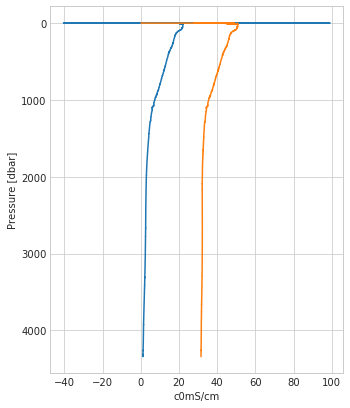

In [4]:
%matplotlib inline

from matplotlib import style
style.use('seaborn-whitegrid')


down['t090C'].plot_cast()
down['c0mS/cm'].plot_cast();

Sometimes it is useful to plot the second variable in a different axis so we can compare the two.

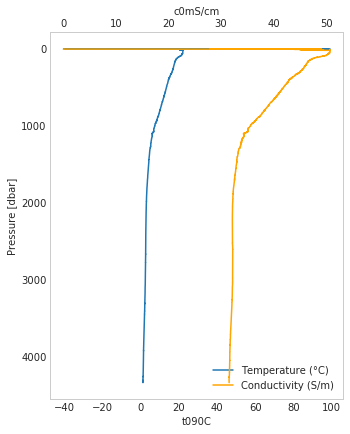

In [5]:
ax0 = down['t090C'].plot_cast(label='Temperature (°C)')
ax1 = down['c0mS/cm'].plot_cast(
    ax=ax0,
    label='Conductivity (S/m)',
    color='orange',
    secondary_y=True,
)


lines = ax0.get_lines() + ax1.get_lines()
leg = {
    line: line.get_label() for line in lines
}
ax0.legend(leg.keys(), leg.values())
ax0.grid(False)
ax1.grid(False)

`python-ctd` saves of the file metadata in a dictionary to make them easy to access later. 

In [6]:
metadata = cast._metadata

metadata.keys()

dict_keys(['header', 'config', 'names', 'skiprows', 'time', 'lon', 'lat', 'name'])

In [7]:
print(metadata['header'])

* Sea-Bird SBE 9 Data File:
* FileName = C:\data\TN366\raw\05001.hex
* Software Version Seasave V 7.26.7.107
* Temperature SN = 2380
* Conductivity SN = 2319
* Number of Bytes Per Scan = 41
* Number of Voltage Words = 4
* Number of Scans Averaged by the Deck Unit = 1
* Append System Time to Every Scan
* System UpLoad Time = May 10 2019 01:34:55
* NMEA Latitude = 34 33.46 S
* NMEA Longitude = 029 30.52 E
* NMEA UTC (Time) = May 10 2019  01:34:56
* Store Lat/Lon Data = Append to Every Scan
* SBE 11plus V 5.2
* number of scans to average = 1
* pressure baud rate = 9600
* NMEA baud rate = 4800
* GPIB address = 1
* advance primary conductivity  0.073 seconds
* advance secondary conductivity  0.073 seconds
* autorun on power up is disabled
* S>
** Ship:
** Station:
** Operator:
* System UTC = May 10 2019 01:34:55
*END*


## Pre-processing steps

Usually the first pre-processing step is to filter the high frequency jitter in the pressure sensor with a low pass filter, here is a zoom in the pressure data (the `pandas` index) demonstrating it:

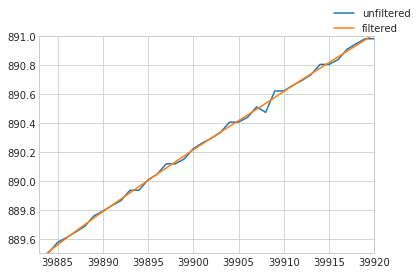

In [8]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(down.index, label='unfiltered')
ax.plot(down.lp_filter().index, label='filtered')
ax.axis([39883, 39920, 889.5, 891])
fig.legend();

Thanks to [pandas_flavor](https://github.com/Zsailer/pandas_flavor) we can chain all the pre-processing steps together.

In [9]:
down = down[['t090C', 'c0mS/cm']]

proc = down.remove_above_water()\
           .despike(n1=2, n2=20, block=100)\
           .lp_filter()\
           .press_check()\
           .interpolate() \
           .bindata(delta=1)\
           .smooth(window_len=21, window='hanning')

proc.head()

,t090C,c0mS/cm
1.5,22.032928,46.534360
2.5,22.008397,47.081194
3.5,21.985663,47.607336
4.5,21.965754,48.089383
5.5,21.949461,48.509991


## CTD derive

Now we can compute all the derived variables.

In [10]:
lon, lat = metadata['lon'], metadata['lat']
lon, lat

(29.508666666666667, -34.55766666666667)

In [11]:
import gsw


p = proc.index

SP = gsw.SP_from_C(proc['c0mS/cm'], proc['t090C'], p)
SA = gsw.SA_from_SP(SP, p, lon, lat)
SR = gsw.SR_from_SP(SP)

CT = gsw.CT_from_t(SA, proc['t090C'].values, p)
z = -gsw.z_from_p(p, lat)
sigma0_CT = gsw.sigma0(SA, CT)

proc = proc.assign(SP=SP)\
           .assign(SA=SA)\
           .assign(SR=SR)\
           .assign(CT=CT)\
           .assign(z=z)\
           .assign(sigma0_CT=sigma0_CT)

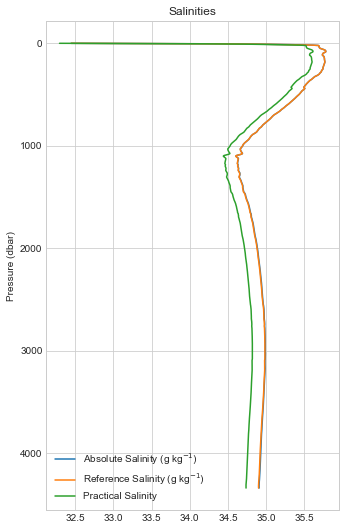

In [12]:
labels = [
    r'Absolute Salinity (g kg$^{-1}$)',
    r'Reference Salinity (g kg$^{-1}$)',
    'Practical Salinity',
]


ax = proc[['SA', 'SR', 'SP']].plot_cast(
    figsize=(5.25, 9),
    label=labels,
)
ax.set_ylabel('Pressure (dbar)')
ax.grid(True)
ax.legend()
ax.set_title('Salinities');

Last but not least let's tweak a three line plot with the main variables measured.

In [13]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

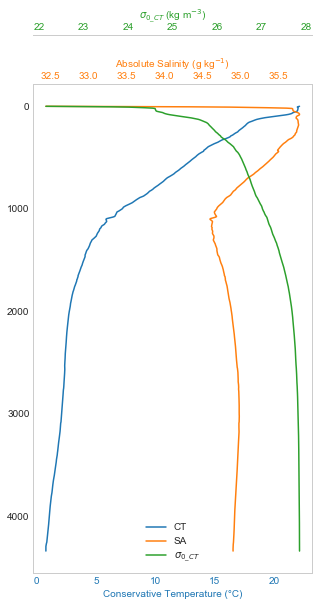

In [14]:
fig, ax0 = plt.subplots(figsize=(5, 9))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax0.invert_yaxis()
ax1 = ax0.twiny()
ax2 = ax0.twiny()

l0, = ax0.plot(proc['CT'], proc.index, color=colors[0], label='CT')
ax0.set_xlabel('Conservative Temperature (°C)')

l1, = ax1.plot(proc['SA'], proc.index, color=colors[1], label='SA')
ax1.set_xlabel('Absolute Salinity (g kg$^{-1}$)')

l2, = ax2.plot(proc['sigma0_CT'], proc.index, color=colors[2], label=r'$\sigma_{0\_CT}$')
ax2.set_xlabel(r'$\sigma_{0\_CT}$ (kg m$^{-3}$)')

make_patch_spines_invisible(ax2)
ax2.spines['top'].set_position(('axes', 1.1))
ax2.spines['top'].set_visible(True)

ax0.xaxis.label.set_color(l0.get_color())
ax1.xaxis.label.set_color(l1.get_color())
ax2.xaxis.label.set_color(l2.get_color())

ax0.tick_params(axis='x', colors=l0.get_color())
ax1.tick_params(axis='x', colors=l1.get_color())
ax2.tick_params(axis='x', colors=l2.get_color())

lines = ax0.get_lines() + ax1.get_lines() + ax2.get_lines()
leg = {
    line: line.get_label() for line in lines
}

ax0.legend(leg.keys(), leg.values(), loc=8)

ax0.grid(False)
ax1.grid(False)
ax2.grid(False)